In [1]:
import cv2
import random
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from glob import glob
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2

In [2]:
data_dir = "/home/pervinco/Datasets/polyp-dataset"

# 1.Data analysis

In [3]:
image_files = sorted(glob(f"{data_dir}/train/train/*"))
mask_files = sorted(glob(f"{data_dir}/train_gt/train_gt/*"))

print(len(image_files), len(mask_files))

1000 1000


/home/pervinco/Datasets/polyp-dataset/train/train/0081835cf877e004e8bfb905b78a9139.jpeg /home/pervinco/Datasets/polyp-dataset/train_gt/train_gt/0081835cf877e004e8bfb905b78a9139.jpeg
(995, 1280, 3) (995, 1280, 3)


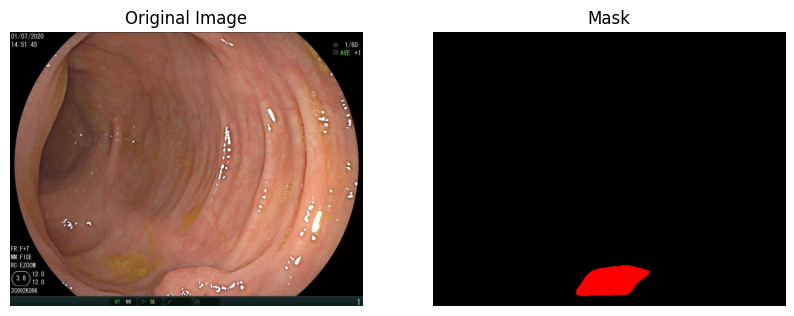

In [4]:
image_file = image_files[0]
mask_file = mask_files[0]
print(image_file, mask_file)

image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_file)
# mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

print(image.shape, mask.shape)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.title('Mask')
plt.axis('off')

plt.show()

In [5]:
gray_mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

unique_values = np.unique(gray_mask)
print(f"Unique pixel values in the mask: {unique_values}")

Unique pixel values in the mask: [ 0  1  2  3  4  5  6  7 69 70 71 72 73 74 75 76 77 78 79 80 81 82]


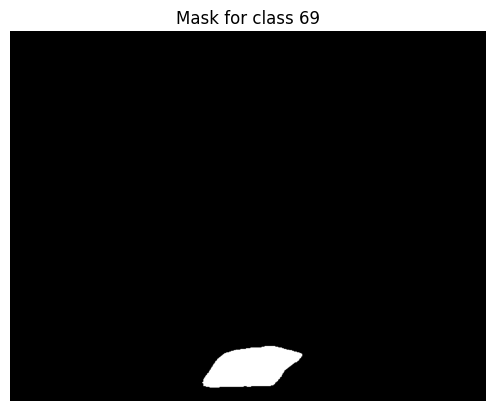

In [6]:
class_value = 69
class_mask = gray_mask >= class_value

plt.imshow(class_mask, cmap='gray')
plt.title(f"Mask for class {class_value}")
plt.axis('off')
plt.show()

위 결과를 봤을 때, [0, 1] 또는 [0, 2]로 구성되지 않고 여러 가지 값들로 구성되어 있음을 볼 수 있다. 결과적으로 마스크 픽셀에 대한 정제가 필요하다.

# 2.Mask Encoding & Decoding

문제를 해결하기 위해 encoding, decoding 함수 정의.

- encoding : HSV 기준 픽셀이 지정된 범위 내에 있는 픽셀인 경우 클래스 1(non-neoplastic polyps), 클래스 2(neoplastic polyps)로 처리. 즉, [0, 1, 2]로 구성되는 binary mask
- decoding : 인코딩된 마스크를 보고 RGB 픽셀로 맵핑.

In [7]:
def mask_encoding(mask):  
    hsv_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)
    
    lower1 = np.array([0, 100, 20])
    upper1 = np.array([10, 255, 255])
    
    lower2 = np.array([160,100,20])
    upper2 = np.array([179,255,255])

    lower_mask = cv2.inRange(hsv_mask, lower1, upper1)
    upper_mask = cv2.inRange(hsv_mask, lower2, upper2)
    red_mask = lower_mask + upper_mask
    red_mask[red_mask != 0] = 2

    green_mask = cv2.inRange(hsv_mask, (36, 25, 25), (70, 255,255))
    green_mask[green_mask != 0] = 1
    full_mask = cv2.bitwise_or(red_mask, green_mask)
    full_mask = full_mask.astype(np.uint8)

    return full_mask


def mask_decoding(mask):
    decoded_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    decoded_mask[mask == 0] = [0, 0, 0]
    decoded_mask[mask == 1] = [0, 255, 0] ## Green
    decoded_mask[mask == 2] = [255, 0, 0] ## Red
    
    return decoded_mask

(995, 1280)
[0 2]


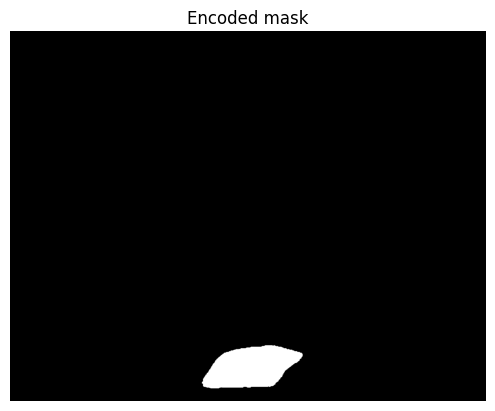

In [8]:
encoded_mask = mask_encoding(mask)
print(encoded_mask.shape)
print(np.unique(encoded_mask))

plt.imshow(encoded_mask, cmap="gray")
plt.title("Encoded mask")
plt.axis('off')
plt.show()

(995, 1280, 3)
[  0 255]


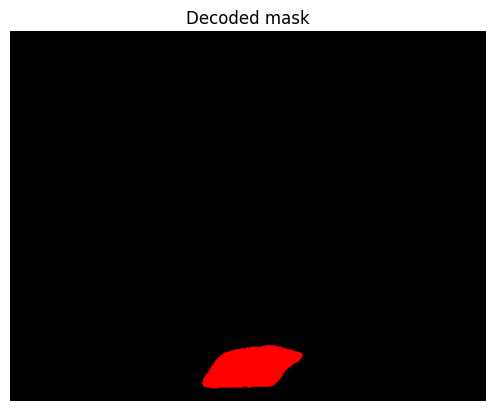

In [9]:
decoded_mask = mask_decoding(encoded_mask)
print(decoded_mask.shape)
print(np.unique(decoded_mask))

plt.imshow(decoded_mask)
plt.title("Decoded mask")
plt.axis('off')
plt.show()

# 3.Class Distribution

각 클래스의 분포를 확인하기 위해 인코딩 마스크를 기반으로 구분한다.
- 1만 존재하는 마스크.
- 2만 존재하는 마스크.
- 1과 2가 동시에 존재하는 마스크.

In [10]:
def sort_masks(mask_files):
    red_masks = []
    green_masks = []
    red_and_green_masks = []
    
    for mask_file in mask_files:
        file_name = mask_file.split("/")[-1].split(".")[0]
        mask = cv2.imread(mask_file)
        encoded_mask = mask_encoding(mask)
        
        if np.any(encoded_mask == 1) and not np.any(encoded_mask == 2):
            green_masks.append(file_name)
        elif np.any(encoded_mask == 2) and not np.any(encoded_mask == 1):
            red_masks.append(file_name)
        elif np.any(encoded_mask == 1) and np.any(encoded_mask == 2):
            red_and_green_masks.append(file_name)
    
    with open('red.txt', 'w') as file:
        for item in red_masks:
            file.write(f"{item}\n")
            
    with open('green.txt', 'w') as file:
        for item in green_masks:
            file.write(f"{item}\n")
            
    with open('red_and_green.txt', 'w') as file:
        for item in red_and_green_masks:
            file.write(f"{item}\n")
    
    print(len(red_masks), len(green_masks), len(red_and_green_masks))
    labels = ['Red Only', 'Green Only', 'Red and Green']
    counts = [len(red_masks), len(green_masks), len(red_and_green_masks)]
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color=['red', 'green', 'orange'])
    plt.title('Mask Type Distribution')
    plt.xlabel('Mask Type')
    plt.ylabel('Count')
    plt.xticks(labels)
    plt.show()

693 257 50


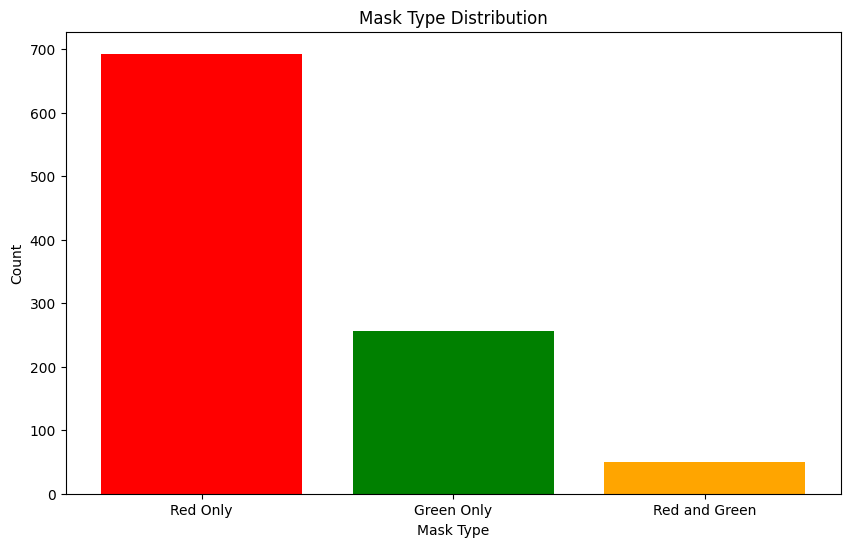

In [11]:
sort_masks(mask_files)

# 4. Split Train/Valid set

In [12]:
def read_file_list(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

In [13]:
red_masks = read_file_list('red.txt')
green_masks = read_file_list('green.txt')
red_and_green_masks = read_file_list('red_and_green.txt')

In [14]:
# 클래스 1과 2가 동시에 존재하는 경우 균등 분배
half_red_and_green = len(red_and_green_masks) // 2
valid_red_and_green = red_and_green_masks[:half_red_and_green]
train_red_and_green = red_and_green_masks[half_red_and_green:]

# 클래스 1과 클래스 2의 1대1 비율을 유지하기 위한 작업
# 가능한 한 많은 클래스 1 데이터를 유지하기 위해, validation set에 클래스 1 데이터를 먼저 할당
valid_green = green_masks[:len(red_masks)//4]  # 전체 클래스 2 데이터의 1/4만큼 클래스 1 데이터를 validation에 할당
train_green = green_masks[len(red_masks)//4:]

# 클래스 2 데이터 중 validation set에 할당되지 않은 나머지를 train set에 할당
valid_red = red_masks[:len(valid_green)]  # validation에 할당된 클래스 1 데이터와 같은 양의 클래스 2 데이터를 validation에 할당
train_red = red_masks[len(valid_green):]

# 최종 train set과 validation set 구성
train_files = train_red + train_green + train_red_and_green
valid_files = valid_red + valid_green + valid_red_and_green

# 결과를 파일에 기록
with open('train.txt', 'w') as file:
    for item in train_files:
        file.write(f"{item}\n")

with open('valid.txt', 'w') as file:
    for item in valid_files:
        file.write(f"{item}\n")

print(f"Train set size: {len(train_files)}, Validation set size: {len(valid_files)}")

Train set size: 629, Validation set size: 371


In [15]:
def split_and_save_files(red_masks, green_masks, red_and_green_masks):
    half_index_red_and_green = len(red_and_green_masks) // 2
    train_red_and_green = red_and_green_masks[:half_index_red_and_green]
    valid_red_and_green = red_and_green_masks[half_index_red_and_green:]

    available_class_2_for_valid = len(green_masks) - (len(red_masks) - len(valid_red_and_green))    
    valid_class_1_amount = min(len(green_masks) // 4, available_class_2_for_valid)
    
    valid_green = green_masks[:valid_class_1_amount]
    train_green = green_masks[valid_class_1_amount:]
    
    valid_red = red_masks[:valid_class_1_amount + len(valid_red_and_green)]
    train_red = red_masks[valid_class_1_amount + len(valid_red_and_green):]

    def save_to_file(file_list, file_name):
        with open(file_name, 'w') as file:
            for item in file_list:
                file.write(f"{item}\n")

    save_to_file(train_red, 'train_red.txt')
    save_to_file(valid_red, 'valid_red.txt')
    save_to_file(train_green, 'train_green.txt')
    save_to_file(valid_green, 'valid_green.txt')
    save_to_file(train_red_and_green, 'train_red_and_green.txt')
    save_to_file(valid_red_and_green, 'valid_red_and_green.txt')


split_and_save_files(red_masks, green_masks, red_and_green_masks)

# 5. Dataset Class

In [16]:
def get_transform(is_train, img_size):
    if is_train:
        transform = A.Compose([
            A.Resize(img_size, img_size, p=1, always_apply=True),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            
            A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
            A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
            
            A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(), A.GaussNoise(), A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),

            A.CoarseDropout(p=0.2, max_height=35, max_width=35, fill_value=0, mask_fill_value=0),
            A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.15, brightness_coeff=1.5, p=0.09),
            A.RandomShadow(p=0.1),
            A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15, rotate_limit=180),
            A.RandomCrop(img_size, img_size)])
    else:
        transform = A.Compose([A.Resize(img_size, img_size, p=1, always_apply=True)])

    return transform

In [17]:
class BKAIDataset(Dataset):
    def __init__(self, txt_path, data_dir, img_size):
        self.img_size = img_size
        self.data_dir = data_dir
        self.image_dir = f"{self.data_dir}/train/train"
        self.mask_dir = f"{self.data_dir}/train_gt/train_gt"
        self.transform = get_transform(is_train=True, img_size=self.img_size)

        with open(txt_path, 'r') as f:
            self.total_files = [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.total_files)
    

    def __getitem__(self, idx):
        file_name = self.total_files[idx]
        print(file_name)
        image_path = f"{self.image_dir}/{file_name}.jpeg"
        mask_path = f"{self.mask_dir}/{file_name}.jpeg"
        print(image_path, mask_path)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path)
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        encoded_mask = mask_encoding(mask)

        return image, encoded_mask

In [18]:
dataset = BKAIDataset("./train.txt", data_dir, img_size=512)

In [19]:
def visualize_dataset_sample(dataset, idx):
    image, encoded_mask = dataset[idx]
    
    # image = image.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # image = std * image + mean
    # image = np.clip(image, 0, 1)
    
    decoded_mask = mask_decoding(encoded_mask)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    axes[1].imshow(decoded_mask)
    axes[1].set_title('Decoded Mask')
    axes[1].axis('off')
    
    plt.show()

3f1f90be28799235026b3550534bca54
/home/pervinco/Datasets/polyp-dataset/train/train/3f1f90be28799235026b3550534bca54.jpeg /home/pervinco/Datasets/polyp-dataset/train_gt/train_gt/3f1f90be28799235026b3550534bca54.jpeg


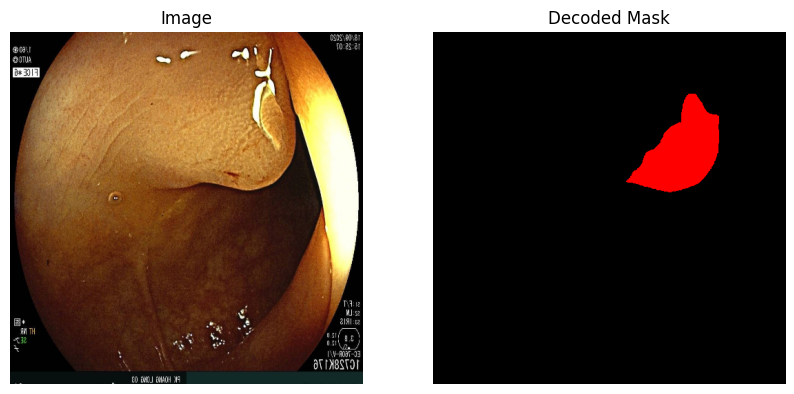

In [20]:
visualize_dataset_sample(dataset, idx=1)